<a href="https://colab.research.google.com/github/EmmanuelADAM/IntelligenceArtificiellePython/blob/master/GymFrozenLakeQLearning.ipynb" target="_parent">Open in Colab</a>

# Machine Learning
## Applied to [Gym.OpenAI](https://gym.openai.com)

---
## Q-Learning to reach the goal

**Using the Gymnasium Environment**
(see the introduction page to [Gym](https://gym.openai.com)).

*If necessary, import gymnasium*

In [ ]:
#!pip install gymnasium

In [46]:
import gymnasium as gym

----
### The FrozenLake Environment

---
- The `FrozenLake` environment is a maze composed of frozen tiles, which can be made slippery. There are holes and a treasure to find.
  - It is possible to use this environment in 'slippery' mode, where applying an *action is not deterministic!*
    - So, from a "frozen" tile, moving right can lead right, or up or down....

**N.B.**
  - *This environment works well under Colab, JupyterLab, etc.*
  - It is highly recommended to start with a deterministic environment to evaluate the proper functioning of the Q-Learning algorithm you will develop.

---
#### Study of the Environment

---
#### Testing Actions

In Gym, `step` allows performing an action. The function returns an observation of the resulting state, its reward, its type (final or not), and some information.
Here, in FrozenLake,
- observation = position where the agent is located
- reward = reward
- done = true if the goal is reached
- info = probability of success of the action
  - in deterministic mode, non-slippery floor, the success probability is 100%
  - in non-deterministic mode, slippery floor, the success probability is 30%

---
**Deterministic Case**

In [47]:
## Example on how to use the FrozenLake environment
# Create the FrozenLake environment (deterministic version, 4x4 grid)
env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=False, render_mode='human')

In [48]:
actions = {"Left":0, "Down":1, "Right":2, "Up":3}
###### Testing actions
observation, _ = env.reset()
print(env.render())
print(f"current position: {observation}")

None
current position: 0


In [49]:
action = actions["Down"]
observation, reward, done, _, _ = env.step(action)
print(env.render())
print(f"current position: {observation}, reward: {reward}, done: {done}")

None
current position: 4, reward: 0.0, done: False


In [50]:
action = actions["Right"]
observation, reward, done, _, info = env.step(action)
print(env.render())
print(f"current position: {observation}, reward: {reward}, !!done: {done}!!")

None
current position: 5, reward: 0.0, !!done: True!!


**Objective:** find the policy, the set of actions that leads to a solution

In [51]:
env.reset()
policy = ["Right", "Right", "Down","Down","Down","Right"]
for a in policy:
    observation, reward, done, _, info = env.step(actions[a])
    print(env.render())
    print(f"current position: {observation}, reward: {reward}, done: {done}, info: {info}")

None
current position: 1, reward: 0.0, done: False, info: {'prob': 1.0}
None
current position: 2, reward: 0.0, done: False, info: {'prob': 1.0}
None
current position: 6, reward: 0.0, done: False, info: {'prob': 1.0}
None
current position: 10, reward: 0.0, done: False, info: {'prob': 1.0}
None
current position: 14, reward: 0.0, done: False, info: {'prob': 1.0}
None
current position: 15, reward: 1.0, done: True, info: {'prob': 1.0}


---
### <font color="red">First Resolution in Deterministic Mode</font>
Important, to validate the learning of your algorithm before moving to non-deterministic mode, it is better to test it on an environment where each action has a 100% success rate. Below is an example on the mini maze.

---
## Example Algorithm

In [81]:
import numpy as np
import random as rnd
from tqdm import tqdm

# Create the environment with the custom map
#env = FrozenLakeWithPenalties.FrozenLakeWithPenalties(desc=map_pen_10x10, is_slippery=False, render_mode='ansi')
#use a standard FrozenLake map 8x8
env = gym.make('FrozenLake-v1', map_name="8x8", is_slippery=False, render_mode='ansi')

directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}

In [53]:
env.reset()
print(env.render())


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG



In [54]:
# Initialize the Q-Table
# As many cells as the environment has, 
# containing as many values as possible actions
# So here a 64 x 4 matrix
Q = np.zeros([env.observation_space.n,env.action_space.n])

### Setting Up Parameters
As a reminder, the simple Q-Learning algorithm is based on this equation:
$Q(s,a) \gets \lambda \times (r + \gamma \times max_{a'}(Q(s', a'))) + (1-\lambda) \times Q(s,a)$ with
  - $\lambda$: learning coefficient
  - $\gamma$: discount coefficient
  - $r$: reward

This equation gives the quality of action *a* from state *s*.

Initially, actions are chosen randomly and noted; then, as tests progress, the most valued actions are chosen. For this, a draw is made; if it is less than an $\epsilon$, the choice is random. This $\epsilon$ decreases as tests progress.

In [55]:
lambda_learn = .2
gamma = 0.8
epsilon = 1.
coef_eps = 0.999

#### Get the Best Action
`argmax(tab)` returns the index of the largest value in the array.

`argmax(Q[2])` therefore returns the number of the most interesting action from state 2.

## The Simple Q-Learning Algorithm

In [56]:
## Simple Q-Learning algorithm
def q_learn(nb_actions=64):
    """
    performs a learning/solution search cycle via simple Q-Learning

    Parameters
    ----------
    epoch: step number

    Returns
    -------
    total_r: total reward
    r: reward of the last state encountered
    states_list: list of states traversed
    actions_list: list of actions performed

    """
    s = env.reset()
    s = s[0]
    total_r = 0
    done = False
    step = 0
    states_list = []
    actions_list = []
    # The Q-Table learning algorithm
    while not done and step < nb_actions:
        step += 1
        # Choose an action by greedily (with noise) picking from Q table
        actions_s = Q[s, :]
        if rnd.random()<epsilon or np.max(actions_s)==0:
            a = rnd.randint(0, env.action_space.n-1)
        else:
            a = np.argmax(actions_s)

        # Get new state and reward from environment
        new_state, r, done,_, _ = env.step(a)

        done = done or r==1


        # To privilege the shortest path, get negative reward every step
        # if r == 0: r = -0.001

        # Q-Learning
        Q[s, a] = (1-lambda_learn)*Q[s, a] + lambda_learn*(r + gamma * np.max(Q[new_state, :]) - Q[s, a])
        s = new_state
        total_r = total_r + r
        states_list.append(s)
        actions_list.append(a)
    return total_r, r, states_list, actions_list

In [57]:
def try_qlearn(nb_episodes = 4000, nb_actions = 64):
    """
    launches nb_episodes times a Q-Learning cycle and memorizes each found solution

    Returns
    -------
    solutions_list: list of solutions (no, total reward, list of states, list of actions)
    """
    global epsilon
    states_list = []
    actions_list = []
    solutions_list = []
    epsilon = 1
    for i in tqdm(range(nb_episodes)):
        # Reset environment and get first new observation
        total_r, r, states_list, actions_list = q_learn(nb_actions)
        epsilon = epsilon * coef_eps
        # memorize if a solution has been found
        if r == 1: solutions_list.append((i, total_r, states_list, actions_list))

    if(len(solutions_list) == 0): print("no solution found!!")
    return solutions_list

## Displaying the Result
Let's now display the list of actions via the Gym environment

In [77]:
def rendu(solutions_list):
    """ displays the shortest sequence of actions to reach the goal from the provided solutions
    Parameters
    ----------
    solutions_list: list of found solutions

    Returns
    -------
    None.
    """
    env = gym.make('FrozenLake-v1',map_name="8x8", is_slippery=False, render_mode='human')
    mini_sol = solutions_list[0]
    mini_actions = mini_sol[2]
    for s in solutions_list:
        if len(s[2]) < len(mini_sol[2]): 
            mini_sol = s
            mini_actions = s[3]
    print("a solution in ", len(mini_sol[2]), " steps: ")
    env.reset()
    print(env.render())
    for a in mini_actions:
        env.step(a)
        print(env.render())


In [78]:
def reset_algo():
    global Q, coef_eps, lambda_learn, gamma,epsilon
    Q = np.zeros([env.observation_space.n,env.action_space.n])
    lambda_learn = .3
    gamma = 0.1
    epsilon = 1.
    coef_eps = 0.999


In [82]:
reset_algo()

In [83]:
## WE LAUNCH THE RESOLUTION:
solutions = try_qlearn(6000, 30)

100%|██████████| 6000/6000 [00:01<00:00, 4467.97it/s]


In [84]:
if(len(solutions)>0):rendu(solutions)
# re-run the block if no solution found

a solution in  14  steps: 
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


In [63]:
import matplotlib.pyplot as plt
def plot_frequence_sol(solutions_list):
    """
    draws the frequency of solutions found
    Parameters
    ----------
    solutions: list of solutions

    Returns
    -------
    None.

    """
    xs = [x[0] for x in solutions_list]
    ys = [y[1] for y in solutions_list]
    plt.figure(figsize=(10, 4))
    plt.plot(xs, ys, '.')
    plt.xlabel("test no")
    plt.ylabel("gain")
    plt.title("Frequency of solution appearance")
    plt.show()



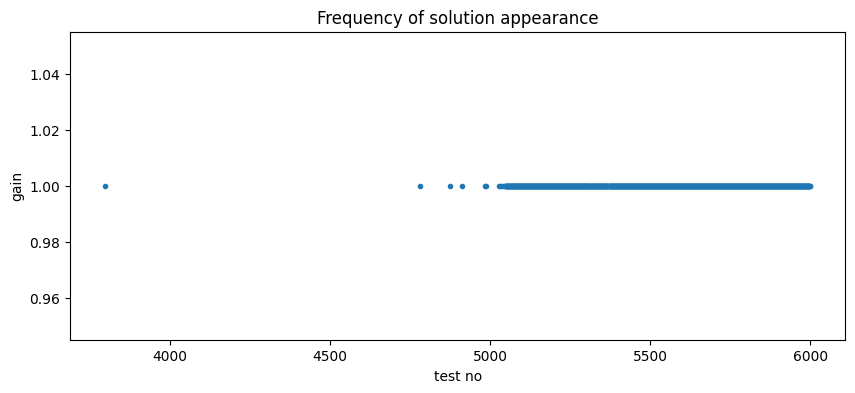

In [64]:
plot_frequence_sol(solutions)

In [65]:
def showBestValues(Q):
    #bestQValues contains the best values of possible actions for each state
    #and we "flatten" the values to reduce their differences (useful for color choices)
    bestQValues = [max(row)**(1/10) for row in Q]
    dim = int(Q.shape[0]**(1/2))
    #we transform bestQValues into a dim x dim matrix
    bestQValues = np.reshape(bestQValues, (dim,dim))
    #we ask python to generate a "heatmap"
    fig, ax = plt.subplots(figsize=(5,5))
    ax.imshow(bestQValues,cmap='Blues')
    plt.title("Best score of an action according to the state")
    plt.show()


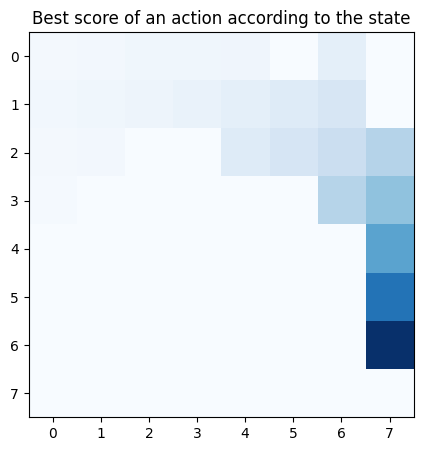

In [66]:
showBestValues(Q)

In [67]:
import seaborn as sns

In [68]:
# Author: Andrea Pierré
# License: MIT License
def qtable_directions_map(qtable, dim):
    """Get the best learned action & map it to arrows."""
    qtable_val_max = qtable.max(axis=1).reshape(dim, dim)+1
    qtable_best_action = np.argmax(qtable, axis=1).reshape(dim, dim)
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = 0#np.finfo(float).min #np.finfo(float).eps  # Minimum float number on the machine
    for idx, val in enumerate(qtable_best_action.flatten()):
        if abs(qtable_val_max.flatten()[idx]-1) > eps:
            qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(dim, dim)
    return qtable_val_max, qtable_directions

In [89]:
# from Author: Andrea Pierré
# License: MIT License
from math import sqrt
sqrt_vect = np.vectorize(sqrt)

def plot_q_values_map(qtable, dim):
    """Plot the last frame of the simulation and the policy learned."""
    qtable_val_max, qtable_directions = qtable_directions_map(qtable, dim)
    # Plot the last frame
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
    # Plot the policy
    sns.heatmap(
        sqrt_vect(sqrt_vect(sqrt_vect(qtable_val_max))),
        annot=qtable_directions,
        fmt="",
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    plt.show()

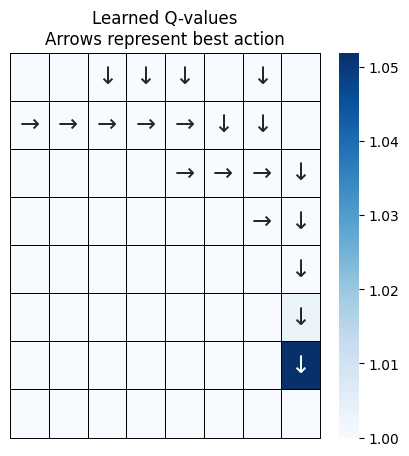

In [70]:
plot_q_values_map(Q,8)

---
### <font color="red">Testing Resolution in Non-Deterministic Mode</font>
Let's reload the environment in "slippery" mode.

Just reset the Q table and launch the algorithm...

100%|██████████| 10000/10000 [00:04<00:00, 2429.65it/s]


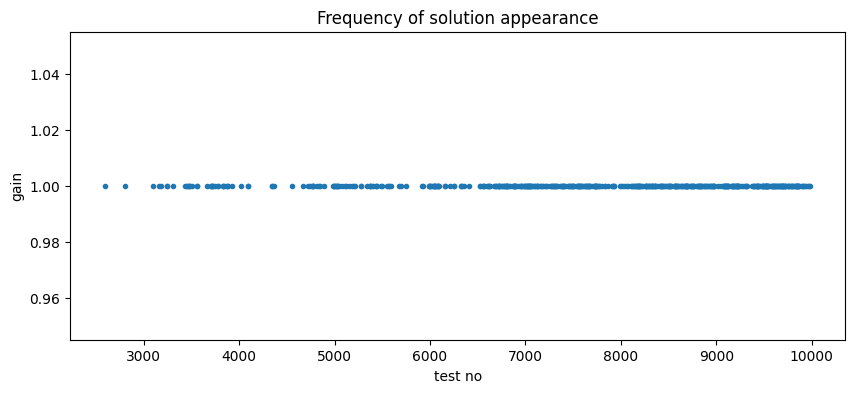

In [71]:
env = gym.make('FrozenLake-v1', map_name="8x8", is_slippery=True, render_mode='ansi')

env.reset()
Q = np.zeros([env.observation_space.n,env.action_space.n])
lambda_learn = .3
gamma = 0.99
epsilon = 1.
## WE LAUNCH THE RESOLUTION:
solutions = try_qlearn(nb_episodes = 10000)
plot_frequence_sol(solutions)

In [72]:
if(len(solutions)>0):rendu(solutions)
print("SOLUTION NOT REACHED even though we followed a winning sequence? -> it's normal, the environment is too unstable.")
print("We only learn the actions that *most likely* lead to a solution")
print("but it is not always guaranteed....")
print("re-run this block several times, after a (long) while the sequence of actions will lead to success....")


a solution in  15  steps: 
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
SOLUTION NOT REACHED even though we followed a winning sequence? -> it's normal, the environment is too unstable.
We only learn the actions that *most likely* lead to a solution
but it is not always guaranteed....
re-run this block several times, after a (long) while the sequence of actions will lead to success....


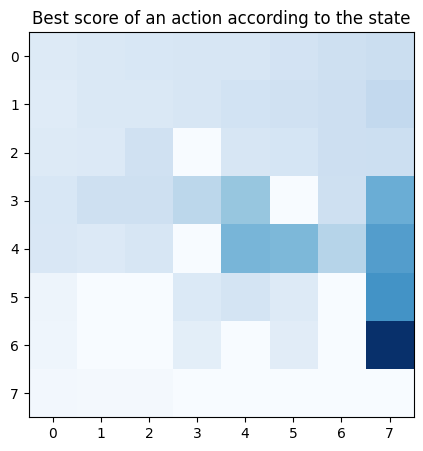

In [73]:
showBestValues(Q)

---
### Double Q Learning

With the Double Q Learning algorithm, we perform, more or less alternately:
  - $a^* \gets argmax_{a} QA(s', a)$,
  - $Q_A(s,a) \gets Q_A(s,a) + \lambda \times (r + \gamma \times Q_B(s', a^*))- Q_A(s,a))$ <br>
or<br>
  - $b^* \gets argmax_{a} Q_B(s', a)$
  - $Q_B(s,a) \gets Q_B(s,a) + \lambda \times (r + \gamma \times QA(s', b^*))- Q_B(s,a))$<br>
with
    - $\lambda$: learning coefficient
    - $\gamma$: discount coefficient
    - $r$: reward

This equation notes the quality of action *a* from state *s* alternately in tables $Q_A$ and $Q_B$.

**Now code the Double Q-Learning algorithm and compare the results** (see [CLIFFDoubleQLearning](https://github.com/EmmanuelADAM/IntelligenceArtificiellePython/blob/master/GymCLIFFDoubleQLearningTODO.ipynb)).

N.B. The parameters allowing good learning by double Q-Learning are:
- lambda_learn = .2
- gamma = 0.99
- epsilon = 1.
- nb_episodes = 3000
- nb_actions = 100

----
### Delayed Q-Learning

For **Delayed Q-Learning**, the goal is to wait before updating the Quality values of the actions.

- We then introduce a list that will contain the encountered values.
- This list $memory$ contains tuples (state, action, reward, new_state)
- The algorithm follows the classic functioning, but after executing an action, the current state, the action, the reward, and the new state obtained are stored in the list $memory$
- Periodically, after $m$ iterations:
    - we scan this list to apply the classic Q-Learning formula and update the Q matrix for each encountered state, action pair
    - we clear the contents of this list.
- The performance of delayed Q-Learning depends on the value m (for example, for m=16, it is only after 16 actions (or after finding the goal, or after the requested actions) that the Q matrix will be updated with all the encountered cases

Delayed Q-Learning allows for greater exploration and reduces cases of local maxima.

**Now code the delayed Q-Learning algorithm** and compare the results.